In [1]:
from utils import readFloatComplex, readShortComplex, readFloat
import matplotlib.pyplot as plt
import numpy as np
import argparse
from skimage.segmentation import mark_boundaries
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from skimage.measure import compare_ssim
from numpy.linalg import norm
import os

from superpixel import superpixel, centroid, highway_pixel,coherence_estimator, oneD_regionProp, centroid_single
from highwayDecomp_gcn import decomposition_highway1, decomposition_super1, decomposition_label

# parser = argparse.ArgumentParser()
# parser.add_argument("--ddir", type=str, default=".")
# args = parser.parse_args()
# args.ddir = ""

IFG_PATH = "1slc1_1slc2.noisy"
COH_PATH = "1slc1_1slc2.filt.coh"
SLC1_PATH = "1slc1.rslc"
SLC2_PATH = "1slc2.rslc"

WIDTH = 300

k=600

In [2]:
ifg = readFloatComplex(IFG_PATH, WIDTH)
coh_3vg = readFloat(COH_PATH, WIDTH)
slc1 = readFloatComplex(SLC1_PATH, WIDTH)
slc2 = readFloatComplex(SLC2_PATH, WIDTH)

# 4D representation

# Dim-0
amp_slc1 = np.abs(slc1)
# Dim-1
amp_slc2 = np.abs(slc2)

# Phase of Ifg
phase_ifg = np.angle(ifg)
# Force amp to one
phase_bar_ifg = 1*np.exp(1j*phase_ifg)

# Dim-2
real_ifg_phase = np.real(phase_bar_ifg)
# Dim-3
imag_ifg_phase = np.imag(phase_bar_ifg)

In [3]:
# 4d Input
input = np.dstack((amp_slc1,amp_slc2,real_ifg_phase,imag_ifg_phase))


superpixel_fz,superpixel_slic=superpixel(input)
print(input.shape)

C:\Users\frinc\Anaconda3\lib\site-packages\skimage\segmentation\_felzenszwalb.py:64: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  min_size=min_size)


Felzenszwalb number of Super Pixels: 6367
SLIC number of Super Pixels: 5625
(300, 300, 4)


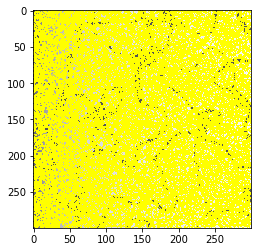

In [4]:
plt.imshow(mark_boundaries(coh_3vg, superpixel_fz))

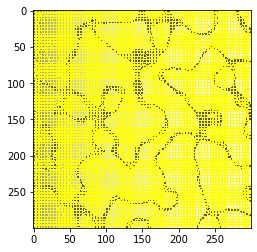

In [5]:
plt.imshow(mark_boundaries(coh_3vg, superpixel_slic))

In [6]:
np.array(superpixel_fz).shape

(300, 300)

In [7]:
np.array(superpixel_slic).shape

(300, 300)

### FZ Algorithm

In [8]:
centroids_super_fz,a1_list,a2_list,real_list,imag_list,coordinates_super_fz = centroid(superpixel_fz,input)

In [9]:
input_fz = np.dstack((a1_list,a2_list,real_list,imag_list))
kmeans_fz = KMeans(n_clusters=k, random_state=0).fit(input_fz.reshape(-1,4))
highway_fz = kmeans_fz.labels_
print(input_fz.shape)
print(f"Fz number of Highway Pixels: {len(np.unique(highway_fz))}")

(1, 6367, 4)
Fz number of Highway Pixels: 600


In [10]:
new_input = highway_pixel(input,superpixel_fz,highway_fz)
centroids_highway_fz,a1_list,a2_list,real_list,imag_list, coordinates_high_fz = centroid_single(highway_fz ,input_fz)
highway_coh = coherence_estimator(new_input,slc1,slc2)

90000 (600,)
(600,)


In [11]:
decom_highway_coh = decomposition_highway1(centroids_highway_fz, highway_fz,highway_coh,coordinates_high_fz,input_fz)
decom_super_coh = decomposition_super1(centroids_super_fz,superpixel_fz,decom_highway_coh,coordinates_super_fz,input)
decom_super_label = decomposition_label(centroids_super_fz,superpixel_fz,decom_highway_coh,coordinates_super_fz,input)

(300, 300)
(300, 300, 4)
(1, 6367, 4)
(300, 300, 4)
(1, 6367, 4)


In [12]:
np.array(decom_super_label).shape

(300, 300)

In [13]:
mses=mean_squared_error(coh_3vg,decom_super_coh)
print("MSE", mses)
print("RMSE",np.sqrt(mses))
(score, diff) = compare_ssim(np.array(coh_3vg), np.array(decom_super_coh), full=True)
diff = (diff * 255).astype("uint8")
print("SSIM: {}".format(score))


MSE 0.027869631068509097
RMSE 0.16694199911498933
SSIM: 0.7268097894019805


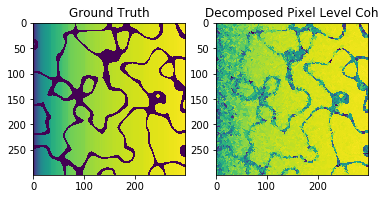

In [14]:
# highway alone
fig, ax = plt.subplots(1, 2)
ax[0].imshow(coh_3vg)
ax[0].set_title("Ground Truth")
ax[1].imshow(decom_super_coh, vmin=np.array(decom_super_coh).min(), vmax = np.array(decom_super_coh).max())
ax[1].set_title("Decomposed Pixel Level Coh")
plt.show()

Input to GCN:
    1. 300x300x4 - 4d input - variable name input
    2. 300x300 highway pixels labels to make adjacency matrix - variable name decom_super_label

### SLIC Algorithm

In [15]:
superpixel_fz = superpixel_slic

In [16]:
centroids_super_fz,a1_list,a2_list,real_list,imag_list,coordinates_super_fz = centroid(superpixel_fz,input)

In [17]:
input_fz = np.dstack((a1_list,a2_list,real_list,imag_list))
kmeans_fz = KMeans(n_clusters=k, random_state=0).fit(input_fz.reshape(-1,4))
highway_fz = kmeans_fz.labels_
print(input_fz.shape)
print(f"Fz number of Highway Pixels: {len(np.unique(highway_fz))}")

(1, 5625, 4)
Fz number of Highway Pixels: 600


In [18]:
new_input = highway_pixel(input,superpixel_fz,highway_fz)
centroids_highway_fz,a1_list,a2_list,real_list,imag_list, coordinates_high_fz = centroid_single(highway_fz ,input_fz)
highway_coh = coherence_estimator(new_input,slc1,slc2)

90000 (600,)
(600,)


In [19]:
decom_highway_coh = decomposition_highway1(centroids_highway_fz, highway_fz,highway_coh,coordinates_high_fz,input_fz)
decom_super_coh = decomposition_super1(centroids_super_fz,superpixel_fz,decom_highway_coh,coordinates_super_fz,input)
decom_super_label = decomposition_label(centroids_super_fz,superpixel_fz,decom_highway_coh,coordinates_super_fz,input)

(300, 300)
(300, 300, 4)
(1, 5625, 4)
(300, 300, 4)
(1, 5625, 4)


In [20]:
mses=mean_squared_error(coh_3vg,decom_super_coh)
print("MSE", mses)
print("RMSE",np.sqrt(mses))
(score, diff) = compare_ssim(np.array(coh_3vg), np.array(decom_super_coh), full=True)
diff = (diff * 255).astype("uint8")
print("SSIM: {}".format(score))

MSE 0.014640016061925817
RMSE 0.12099593407187623
SSIM: 0.7773002161313073


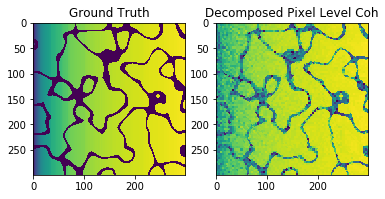

In [21]:
# highway alone
fig, ax = plt.subplots(1, 2)
ax[0].imshow(coh_3vg)
ax[0].set_title("Ground Truth")
ax[1].imshow(decom_super_coh, vmin=np.array(decom_super_coh).min(), vmax = np.array(decom_super_coh).max())
ax[1].set_title("Decomposed Pixel Level Coh")
plt.show()